<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Graph-layout" data-toc-modified-id="Graph-layout-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Graph layout</a></span></li><li><span><a href="#Color-compounds-by-omics-level-and-pvalue" data-toc-modified-id="Color-compounds-by-omics-level-and-pvalue-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Color compounds by omics level and pvalue</a></span></li><li><span><a href="#Big-venn-diagram" data-toc-modified-id="Big-venn-diagram-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Big venn diagram</a></span></li><li><span><a href="#Network-plot" data-toc-modified-id="Network-plot-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Network plot</a></span></li></ul></div>

In [1]:
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import networkx as nx
import seaborn as sns
import matplotlib as mpl

from matplotlib_venn import venn2, venn3
%matplotlib inline

np.random.seed(0)

In [2]:
rna_edges = pd.read_parquet('../results/rna_compound_edges.parquet')
wgs_edges = pd.read_parquet('../results/wgs_compound_edges.parquet')
#amp_edges = pd.read_parquet('../results/amp_compound_edges.parquet')

In [3]:
#edges = pd.concat((wgs_edges, amp_edges, rna_edges))
edges = pd.concat((wgs_edges, rna_edges))
edges = edges.drop_duplicates()

In [4]:
graph = nx.from_pandas_edgelist(edges, 'src', 'dest')

In [5]:
nx.number_connected_components(graph)

2

In [6]:
components = nx.connected_components(graph)

In [7]:
for c in components:
    print('Nodes', len(c))

Nodes 5199
Nodes 64


# Graph layout

In [8]:
components = nx.connected_components(graph)
comp = next(components) # get first component, since it is the largest

In [9]:
#pos.loc[list(comp)].to_csv('../results/connected_compound_positions.csv')
pos = pd.read_csv('../results/compound_positions.csv', index_col=0)

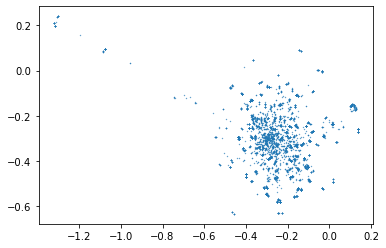

In [10]:
cpos = pos.loc[list(comp)]
epos = pos.loc[list(set(pos.index) - comp)]
k = 4
off = 0.3
cpos = cpos * k - off
plt.scatter(cpos.values[:, 0], cpos.values[:, 1], s=.1)
#plt.scatter(epos.values[:, 0], epos.values[:, 1], s=1)

In [11]:
#new_pos = pd.concat((cpos, epos))
new_pos = cpos

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


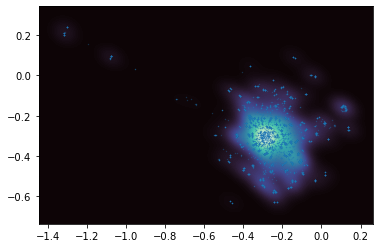

In [12]:
sns.kdeplot(new_pos.values[:, 0], new_pos.values[:, 1], cmap='mako', fill=True, thresh=0, levels=100)
plt.scatter(cpos.values[:, 0], cpos.values[:, 1], s=.1, alpha=0.5)
#plt.scatter(epos.values[:, 0], epos.values[:, 1], s=1)

# Color compounds by omics level and pvalue

In [13]:
rna_compounds = pd.read_csv('../results/RNA_compounds.csv', index_col=0)
#wgs_compounds = pd.read_csv('../results/WGS_compounds.csv', index_col=0)
amp_compounds = pd.read_csv('../results/16S_compounds.csv', index_col=0)

In [14]:
rna_logpvals = rna_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()
#wgs_logpvals = wgs_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()
amp_logpvals = amp_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()

In [15]:
#wgs_pos = pd.merge(new_pos, wgs_logpvals, left_index=True, right_index=True)
amp_pos = pd.merge(new_pos, amp_logpvals, left_index=True, right_index=True)
rna_pos = pd.merge(new_pos, rna_logpvals, left_index=True, right_index=True)

In [16]:
micro = amp_pos
new_pos = pd.concat((amp_pos, rna_pos))

<AxesSubplot:xlabel='-log(pvalue)', ylabel='Count'>

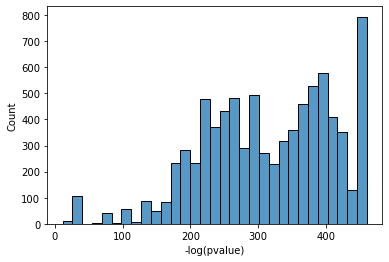

In [17]:
sns.histplot(new_pos['-log(pvalue)'])

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No handles with labels found to put in legend.


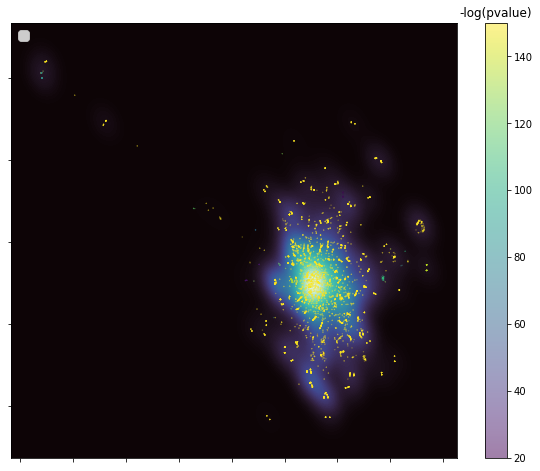

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.kdeplot(new_pos.values[:, 0], new_pos.values[:, 1], cmap='mako', fill=True, thresh=0, levels=100, ax=ax)
norm = mpl.colors.Normalize(vmin=20, vmax=150)
cbar = ax.scatter(new_pos.values[:, 0], new_pos.values[:, 1], s=.1, c=new_pos['-log(pvalue)'], 
                  norm=norm, alpha=0.5)
#ax.scatter(rna_pos.values[:, 0], rna_pos.values[:, 1], s=1, c='r', marker='x', label='RNAseq')

ax.set_xticklabels([])
ax.set_yticklabels([])
clb = plt.colorbar(cbar)
clb.ax.set_title('-log(pvalue)')
lgnd = ax.legend(loc=2, fontsize=14)
for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])

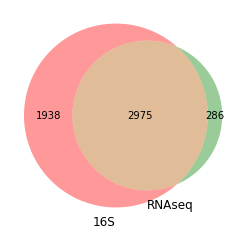

In [19]:
venn2([set(amp_pos.index), set(rna_pos.index)], ['16S', 'RNAseq'])

In [20]:
rna_compounds = pd.read_csv('../results/RNA_compounds.csv', index_col=0)
wgs_compounds = pd.read_csv('../results/WGS_compounds.csv', index_col=0)
#amp_compounds = pd.read_csv('../results/16S_compounds.csv', index_col=0)

# Big venn diagram

In [21]:
rna_comps = rna_compounds[['Name', 'Compound']]
#amp_comps = amp_compounds[['Name', 'Compound']]
wgs_comps = wgs_compounds[['Name', 'Compound']]

all_comps = pd.merge(rna_comps, wgs_comps, left_on='Compound', right_on='Compound', how='outer')
all_comps = all_comps.dropna().drop_duplicates()
all_comps['num_compounds'] = 1
all_comps = all_comps.rename(columns={'Name_x': 'Human pathways', 'Name_y': 'Microbial pathways'})
all_comps = all_comps.groupby(['Human pathways', 'Microbial pathways']).sum().reset_index()
sub_comps = all_comps.loc[all_comps['num_compounds'] >= 20]

sub_comps['Human pathways'] = sub_comps['Human pathways'].apply(
    lambda x: x.replace(' - Homo sapiens (human)', ''))

all_mat = pd.pivot(data=sub_comps, index='Human pathways', columns='Microbial pathways', 
                   values='num_compounds').fillna(0)

<ipython-input-21-c33cca59d17d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_comps['Human pathways'] = sub_comps['Human pathways'].apply(


In [22]:
all_mat = all_mat.sort_index().T.sort_index()

In [23]:
sub_comps.sort_values('num_compounds', ascending=False).head(10)

,Human pathways,Microbial pathways,num_compounds
12349,Porphyrin and chlorophyll metabolism,Porphyrin and chlorophyll metabolism,143
0,ABC transporters,ABC transporters,138
9329,Metabolism of xenobiotics by cytochrome P450,Metabolism of xenobiotics by cytochrome P450,121
1026,Amino sugar and nucleotide sugar metabolism,Amino sugar and nucleotide sugar metabolism,108
4410,Drug metabolism - cytochrome P450,Drug metabolism - cytochrome P450,100
13057,Purine metabolism,Purine metabolism,95
15646,Tryptophan metabolism,Tryptophan metabolism,83
9850,"Neomycin, kanamycin and gentamicin biosynthesis","Neomycin, kanamycin and gentamicin biosynthesis",81
2984,Chemical carcinogenesis - DNA adducts,Chemical carcinogenesis - DNA adducts,81
15927,Tyrosine metabolism,Tyrosine metabolism,78


In [24]:
sub_comps.to_csv('../results/compound_subset.csv')

In [25]:
idx = sub_comps['Human pathways'] != sub_comps['Microbial pathways']
sub_comps.loc[idx]

,Human pathways,Microbial pathways,num_compounds
1052,Amino sugar and nucleotide sugar metabolism,O-Antigen nucleotide sugar biosynthesis,47
1129,Aminoacyl-tRNA biosynthesis,Protein digestion and absorption,21
1861,Ascorbate and aldarate metabolism,Pentose and glucuronate interconversions,23
2995,Chemical carcinogenesis - DNA adducts,Metabolism of xenobiotics by cytochrome P450,40
4946,Fatty acid degradation,Fatty acid elongation,29
4997,Fatty acid elongation,Fatty acid degradation,29
6612,Glyoxylate and dicarboxylate metabolism,Carbon fixation pathways in prokaryotes,22
8003,Inositol phosphate metabolism,Phosphatidylinositol signaling system,23
9324,Metabolism of xenobiotics by cytochrome P450,Chemical carcinogenesis - DNA adducts,40
11563,Pentose and glucuronate interconversions,Ascorbate and aldarate metabolism,23


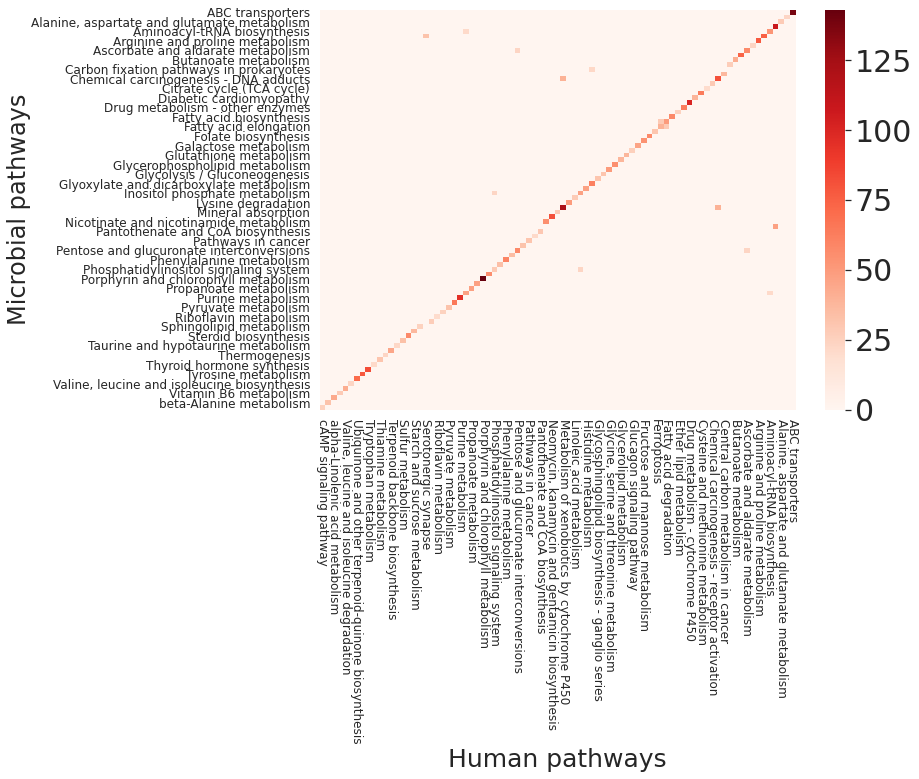

In [26]:
sns.set(font_scale=1.1)
sns.set_style('whitegrid')
#with plt.style.context('dark_background'):

fig, ax = plt.subplots(figsize=(13, 11))
g = sns.heatmap(all_mat.iloc[::-1, :].sort_index().T.sort_index(ascending=False).T, 
                ax=ax, cbar=True, cmap='Reds')
ax.tick_params(axis='x', labelrotation = 270)
ax.set_ylabel('Microbial pathways', rotation=90, labelpad=0, fontsize=24)
ax.set_xlabel('Human pathways', fontsize=25)
plt.tight_layout()

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

#_ = ax.set_xticklabels(g.get_xticks(), rotation = 45)

In [27]:
pwy_pairs = sub_comps.reset_index()
del pwy_pairs['index']
pwy_pairs.to_csv('../results/supplemental_tables/Table_S14.csv')

In [28]:
sub_comps

,Human pathways,Microbial pathways,num_compounds
0,ABC transporters,ABC transporters,138
203,AMPK signaling pathway,AMPK signaling pathway,23
579,"Alanine, aspartate and glutamate metabolism","Alanine, aspartate and glutamate metabolism",28
1026,Amino sugar and nucleotide sugar metabolism,Amino sugar and nucleotide sugar metabolism,108
1052,Amino sugar and nucleotide sugar metabolism,O-Antigen nucleotide sugar biosynthesis,47
...,...,...,...
16165,"Valine, leucine and isoleucine degradation","Valine, leucine and isoleucine degradation",42
16391,Vitamin B6 metabolism,Vitamin B6 metabolism,29
16591,alpha-Linolenic acid metabolism,alpha-Linolenic acid metabolism,44
16659,beta-Alanine metabolism,beta-Alanine metabolism,32


In [29]:
break

SyntaxError: 'break' outside loop (<ipython-input-29-6aaf1f276005>, line 1)

In [ ]:
g.get_xticklabels()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 40))
all_mat.sum(axis=1).sort_values().plot.barh(ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 40))
all_mat.sum(axis=0).sort_values().plot.barh(ax=ax)

Higher level information

In [ ]:
rna_comps = rna_compounds.sort_values('Name')[['Name', 'Compound']]
#amp_comps = amp_compounds.sort_values('Name')[['Name', 'Compound']]
wgs_comps = wgs_compounds.sort_values('Name')[['Name', 'Compound']]

all_comps = pd.merge(rna_comps, amp_comps, left_on='Compound', right_on='Compound', how='outer')
all_comps = all_comps.dropna().drop_duplicates()
all_comps['value'] = 1
all_comps = all_comps.rename(columns={'Name_x': 'Human pathways', 'Name_y': 'Microbial pathways'})
all_comps = all_comps.groupby(['Human pathways', 'Microbial pathways']).sum().reset_index()

In [ ]:
all_comps

In [ ]:
all_mat = pd.pivot(data=all_comps, index='Human pathways', columns='Microbial pathways', values='value').fillna(0)

In [ ]:
sns.heatmap(all_mat, robust=True)

In [ ]:
rna_comps = rna_compounds.sort_values('Name')
#amp_comps = amp_compounds.sort_values('Name')
wgs_comps = wgs_compounds.sort_values('Name')

#all_comps = pd.merge(rna_comps, amp_comps, left_on='Compound', right_on='Compound', how='outer')
all_comps = pd.merge(rna_comps, wgs_comps, left_on='Compound', right_on='Compound', how='outer')

Plot overlap between human and microbial compounds

In [ ]:
rna_asd_comps = rna_compounds.loc[rna_compounds['class'] == 'ASD-associated']
rna_con_comps = rna_compounds.loc[rna_compounds['class'] == 'control-associated']

#amp_asd_comps = amp_compounds.loc[amp_compounds['class'] == 'ASD-associated']
#amp_con_comps = amp_compounds.loc[amp_compounds['class'] == 'control-associated']
wgs_asd_comps = wgs_compounds.loc[amp_compounds['class'] == 'ASD-associated']
wgs_con_comps = wgs_compounds.loc[amp_compounds['class'] == 'control-associated']

#comp_df_list = [amp_asd_comps, amp_con_comps, rna_asd_comps, rna_con_comps]
comp_df_list = [wgs_asd_comps, wgs_con_comps, rna_asd_comps, rna_con_comps]
mat = np.zeros((4, 4))
for i, comp_df in enumerate(comp_df_list):
    for j, comp_df2 in enumerate(comp_df_list):
        mat[i, j] = len(set(comp_df['Compound']) & set(comp_df2['Compound']))
col_names = ['Microbe (ASD)', 'Microbe (Control)', 'Human (ASD)', 'Human (Control)']
mat = pd.DataFrame(mat, columns=col_names, index=col_names)

In [ ]:
sns.heatmap(mat, annot=True)

# Network plot

In [ ]:
rna_compounds.loc[rna_compounds['class'] == 'control-associated'].Name.value_counts().head(50)

In [ ]:
rna_compounds.Name.value_counts().head(50)

In [ ]:
nucleotide = ['Amino sugar and nucleotide sugar metabolism', 
              'Pyrimidine metabolism', 'Purine metabolism']
amino_acid = ['Arginine and proline metabolism',
              'Phenylalanine metabolism', 
              'Tyrosine metabolism', 
              'Lysine degradation',
              'Glycine, serine and threonine metabolism',
              'Histidine metabolism',
              'Valine, leucine and isoleucine degradation',
              'Cysteine and methionine metabolism']
carbohydrate = ['Fructose and mannose metabolism', 
                'Glyoxylate and dicarboxylate metabolism',
                'Fatty acid degradation',
                'Starch and sucrose metabolism',
                'Pentose phosphate pathway',
                'Propanoate metabolism',
                'Butanoate metabolism',
                'Nicotinate and nicotinamide metabolism']
lipid = ['Glycerolipid metabolism', 'Glycerophospholipid metabolism']

In [ ]:
def wgs_pathway_f(x):
    if x['Name'] in nucleotide:
        return 'Nucleotide\nmetabolism'
    if x['Name'] in amino_acid:
        return 'Amino acid\nmetabolism'
    if x['Name'] in carbohydrate:
        return 'Carbohydrate\nmetabolism'
    if ('lipid' in x['Name'] or 'Lipid' in x['Name']) and 'metabolism' in x['Name']:
        return 'Lipid\nmetabolism'
#amp_compounds['Pathway_name'] = amp_compounds.apply(wgs_pathway_f, axis=1)
wgs_compounds['Pathway_name'] = amp_compounds.apply(wgs_pathway_f, axis=1)

In [ ]:
wgs_compounds['Pathway_name'].value_counts()

In [ ]:
human_pathways = ['Pathways of neurodegeneration - multiple diseases - Homo sapiens (human)',
                  'Fatty acid degradation - Homo sapiens (human)',
                  'Tryptophan metabolism - Homo sapiens (human)',
                  'Purine metabolism - Homo sapiens (human)',
                  'Bile secretion - Homo sapiens (human)',
                  'Carbohydrate digestion and absorption - Homo sapiens (human)']


def human_pathway_f(x):
    if x['Name'] == 'Pathways of neurodegeneration - multiple diseases - Homo sapiens (human)':
        return 'Neuro-\ndegeneration'
    if x['Name'] == 'Fatty acid degradation - Homo sapiens (human)':
        return 'Fatty acid \ndegradation'
    if x['Name'] == 'Tryptophan metabolism - Homo sapiens (human)':
        return 'Tryptophan\nmetabolism'
    #if x['Name'] == 'Bile secretion - Homo sapiens (human)':
    #    return 'Bile \n secretion'
    if x['Name'] == 'Purine metabolism - Homo sapiens (human)':
        return 'Purine\nmetabolism'
    if x['Name'] == 'Carbohydrate digestion and absorption - Homo sapiens (human)':
        return 'Carbohydrate\ndigestion\nand absorption'
rna_compounds['Pathway_name'] = rna_compounds.apply(human_pathway_f, axis=1)

In [ ]:
# remove redundancy
new_pos = new_pos.reset_index().groupby('index').max()

In [ ]:
cmap = plt.get_cmap('Greens')

amp_attr = {
    'Nucleotide\nmetabolism': {'dx': 0, 'dy': 0.2, 'color': cmap(0.7)},
    'Carbohydrate\nmetabolism': {'dx': -0.55, 'dy': -0.1, 'color': cmap(0.8)},
    'Amino acid\nmetabolism': {'dx': 0.15, 'dy': -0.35, 'color': cmap(0.9)},
    'Lipid\nmetabolism': {'dx': -0.2, 'dy': 0.2, 'color': cmap(1.0)}
}

cmap = plt.get_cmap('YlOrBr')
rna_attr = {
    'Neuro-\ndegeneration': {'dx': 0.2, 'dy': -0.1, 'color': cmap(0.6)},
    'Fatty acid \ndegradation': {'dx': -0.4, 'dy': -0.35, 'color': cmap(0.9)},
    'Tryptophan\nmetabolism': {'dx': -0.15, 'dy': -0.3, 'color': cmap(0.7)},
    'Purine\nmetabolism': {'dx': 0.2, 'dy': 0.1, 'color': cmap(0.5)},
    'Carbohydrate\ndigestion\nand absorption': {'dx': -0.5, 'dy': -0, 'color': cmap(1.0)}
}

In [ ]:
from scipy.spatial import ConvexHull
import matplotlib.patches as mpatches 

fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(new_pos.values[:, 0], new_pos.values[:, 1], 
            cmap='Greys', fill=False, thresh=0, levels=10, ax=ax)

for name, df in wgs_compounds.groupby('Pathway_name'):
    compounds = df['Compound'].unique()
    points = new_pos.loc[compounds, ['0', '1']].values
    hull = ConvexHull(points)
    dx, dy, color = wgs_attr[name]['dx'], wgs_attr[name]['dy'], wgs_attr[name]['color']
    #ax.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
    tri = mpatches.Polygon(points[hull.vertices], closed=True, color=color, alpha=0.1)   
    ax.add_patch(tri)     
    ax.annotate(name, xy=points.mean(0), xytext=points.mean(0) + np.array([dx, dy]),
                xycoords='data',
                arrowprops=dict(arrowstyle= '->',
                             color=color,
                             lw=3,
                             ls='-'),
                color=color, fontsize=14)
    
for name, df in rna_compounds.groupby('Pathway_name'):
    compounds = df['Compound'].unique()
    compounds = list(set(compounds) & set(new_pos.index))
    points = new_pos.loc[compounds, ['0', '1']].values
    hull = ConvexHull(points)
    dx, dy, color = rna_attr[name]['dx'], rna_attr[name]['dy'], rna_attr[name]['color']
    tri = mpatches.Polygon(points[hull.vertices], closed=True, color=color, alpha=0.2)   
    ax.add_patch(tri)     
    ax.annotate(name, xy=points.mean(0), xytext=points.mean(0) + np.array([dx, dy]),
                xycoords='data',
                arrowprops=dict(arrowstyle= '->',
                             color=color,
                             lw=3,
                             ls='-'),
                color=color, fontsize=14)
    
norm = mpl.colors.Normalize(vmin=20, vmax=150)
cbar = ax.scatter(new_pos.values[:, 0], new_pos.values[:, 1], s=.1, c=new_pos['-log(pvalue)'], 
                  norm=norm, alpha=0.3)

clb = plt.colorbar(cbar)
clb.ax.set_title('-log(pvalue)')
lgnd = ax.legend(loc=2, fontsize=16)

#ax.set_xticklabels([])
#ax.set_yticklabels([])
ax.set_xlim([-0.9, 0.4])
ax.set_ylim([-0.9, 0.4])
ax.get_legend().remove()
clb.ax.tick_params(labelsize=14) 
fig.patch.set_visible(False)
ax.axis('off')